In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.splits = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        self.data_discretization(train_features)
        features_all = [self.classify_sample(feature) for feature in train_features]
        for cl in set(train_classes):
            features = [merged[0] for merged in zip(features_all, train_classes) if merged[1] == cl]
            self.priors[cl] = len(features) / len(features_all)
            self.likelihoods[cl] = []
            for i in range(len(features[0])):
                feature = [sample[i] for sample in features]
                self.likelihoods[cl].append([feature.count(j) / len(features) for j in range(4)])

    def data_discretization(self, data):
        for i in range(len(data[0])):
            new_data = sorted([sample[i] for sample in data])
            self.splits[i] = new_data[len(new_data)//4], new_data[len(new_data)*2//4], new_data[len(new_data)*3//4]

    def classify_sample(self, sample):
        converted_sample = []
        for i, value in enumerate(sample):
            for j in range(3):
                if value < self.splits[i][j]:
                    converted_sample.append(j)
                    break
            if value >= self.splits[i][2]:
                converted_sample.append(3)
        return converted_sample

    def predict(self, sample):
        best_class = None
        best_probability = -1
        for cl in self.likelihoods.keys():
            probability = self.priors[cl]
            for i, value in enumerate(self.classify_sample(sample)):
                probability *= self.likelihoods[cl][i][value]
            if probability > best_probability:
                best_probability = probability
                best_class = cl
        return best_class


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.distributions = {}

    def build_classifier(self, train_features, train_classes):
        for cl in set(train_classes):
            features = [merged[0] for merged in zip(train_features, train_classes) if merged[1] == cl]
            self.priors[cl] = len(features) / len(train_features)
            self.distributions[cl] = []
            for i in range(len(features[0])):
                feature = [sample[i] for sample in features]
                self.distributions[cl].append((np.mean(feature), np.var(feature)))

    @staticmethod
    def normal_conditional(x, distribution):
        mean, var = distribution
        exp = - (x - mean) ** 2 / 2 / var
        return np.e ** exp / (2 * np.pi * var)**0.5

    def predict(self, sample):
        best_class = None
        best_probability = -1
        for cl in self.distributions.keys():
            probability = self.priors[cl]
            for i, value in enumerate(sample):
                probability *= self.normal_conditional(value, self.distributions[cl][i])
            if probability > best_probability:
                best_probability = probability
                best_class = cl
        return best_class

Implementacje naiwnego klasyfikatora Bayesa korzystające z dyskretyzacji danych lub rozkładu Gaussa.

In [2]:
iris = load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, random_state=123)

classificator = NaiveBayes()
classificator.build_classifier(x_train, y_train)
for x, y in zip(x_test, y_test):
    print(classificator.predict(x), y)

print()

classificator = GaussianNaiveBayes()
classificator.build_classifier(x_train, y_train)
for x, y in zip(x_test, y_test):
    print(classificator.predict(x), y)

1 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2

1 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2


Wyniki działania obu klasyfikatorów dla zadanych parametrów: seed 123 i zbiór testowy jako 10% całego zbioru. Dla obu wersji program poprawnie zaklasyfikował wszystkie próbki.

In [3]:
def test(test_size, gaussian):
    iris = load_iris()
    x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=test_size)
    if gaussian:
        classificator = GaussianNaiveBayes()
    else:
        classificator = NaiveBayes()
    classificator.build_classifier(x_train, y_train)

    hits = 0
    for x, y in zip(x_test, y_test):
        if classificator.predict(x) == y:
            hits += 1
    return hits / len(y_test)


def benchmark(test_sizes, tests):
    results = []
    for test_size in test_sizes:
        avg = 0
        for i in range(tests):
            avg += test(test_size, False)
        results.append(avg / tests)

    results_gaussian = []
    for test_size in test_sizes:
        avg = 0
        for i in range(tests):
            avg += test(test_size, False)
        results_gaussian.append(avg / tests)

    fig, ax = plt.subplots()
    ax.plot(test_sizes, results, label='Accuracy - discrete')
    ax.plot(test_sizes, results_gaussian, label='Accuracy - Gaussian')
    ax.legend()
    plt.title(f"Accuracies of naive discrete/Gaussian Bayes classifier with various test size ratios")
    plt.show()

    return results, results_gaussian

Funkcje do testowania dokładności obu wersji klasyfikatora - dla obu wersji zostaje wykonane n podziałów zbioru i mierzona jest średnia celność programu. Testowane są różne podziały zbioru treningowego i testowego. Poniżej znajduje się uruchomienie testu:

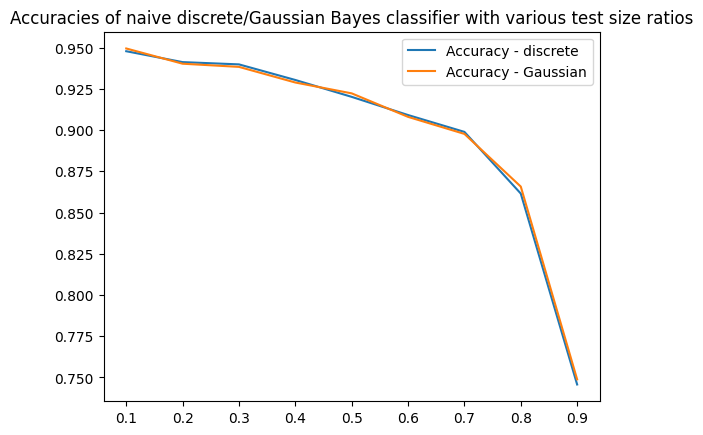

([0.9477999999999912,
  0.9411999999999936,
  0.9398222222222149,
  0.9303666666666663,
  0.9201333333333334,
  0.9091111111111094,
  0.898895238095236,
  0.8614999999999996,
  0.7457629629629631],
 [0.9494666666666586,
  0.9402333333333281,
  0.9383111111111035,
  0.9288333333333307,
  0.9222533333333344,
  0.9079999999999999,
  0.8976761904761882,
  0.8657499999999988,
  0.7488518518518527])

In [4]:
benchmark([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 1000)

Oba klasyfikatory mają podobną celność dla tego zbioru - 95%; można też zauważyć, że zmniejszanie zbioru treningowego pogarsza jakość, bo program ma mniej informacji.

W ogólnym przypadku wersja dyskretna może wymagać bardzo drobnego podziału próbek, by być wystarczająco dokładna, ale poradzi sobie z bardziej skomplikowanymi rozkładami atrybutów. Model Gaussowski działa precyzyjniej, ale można go zastosować tylko wtedy, gdy wartości atrybutów mierzone dla poszczególnych klas mają rozkład Gaussa lub zbliżony do niego.

Tutaj rozkład danych nadaje się do wykorzystania klasyfikatora Gaussa, a dyskretyzacja na 4 wartości okazuje się być wystarczająca, by oba modele dały zadowalające wyniki.